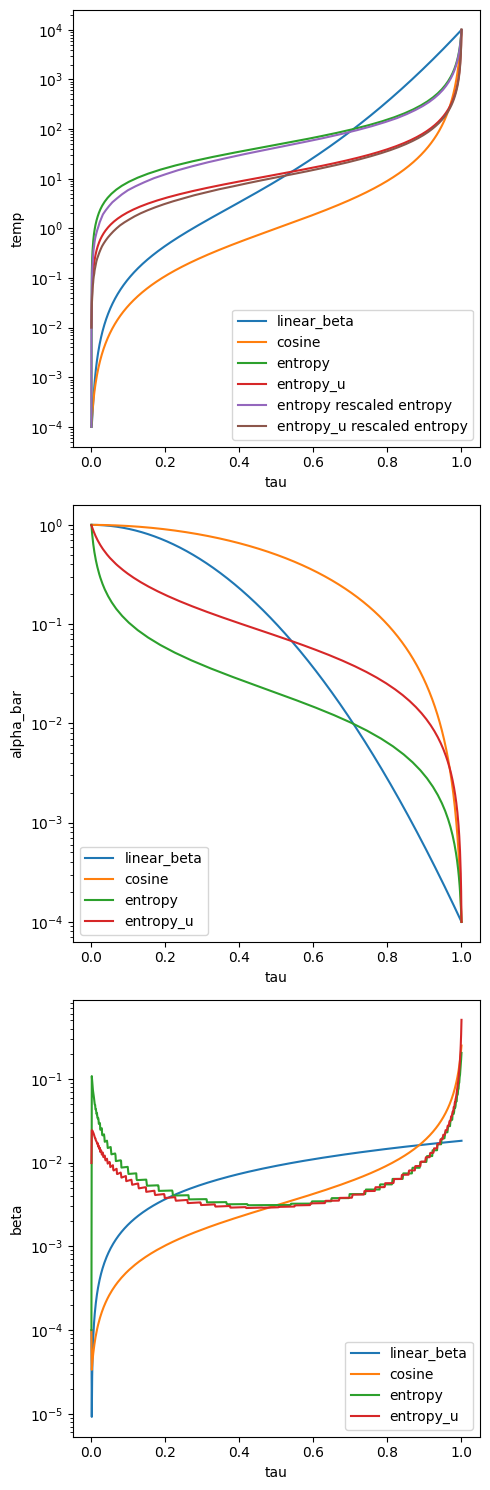

In [5]:
from config import load_config
from diffusion import get_temp_schedule, DynamicCoeffs
import matplotlib.pyplot as plt
from torch import linspace
import numpy as np


config = load_config()
config.data.dataset_name = "cifar10"
tau = linspace(0, 1, 1000)
coeffs_dict: dict[str, DynamicCoeffs] = {}
for noise_schedule in [
    "linear_beta",
    "cosine",
    "entropy",
    "entropy_u",
]:
    config.diffusion.noise_schedule = noise_schedule
    coeffs_dict[noise_schedule] = DynamicCoeffs(get_temp_schedule(config)(tau))

coeff_names = ["temp", "alpha_bar", "beta"]


plt.figure(figsize=(5, len(coeff_names) * 5))

for i, coeff_name in enumerate(coeff_names, 1):
    plt.subplot(len(coeff_names), 1, i)
    for name, coeffs in coeffs_dict.items():
        plt.plot(tau, getattr(coeffs, coeff_name), label=name)

    if coeff_name == "temp":
        for noise_schedule in ["entropy", "entropy_u"]:
            config.diffusion.noise_schedule = noise_schedule
            stats = np.load(config.flattening_temp_stats_path)
            temp = stats["temp"]
            tau_ = stats["log_Z"] + stats["U"] / temp
            tau_ -= tau_.min()
            tau_ /= tau_.max()
            plt.plot(tau_, temp, label=f"{noise_schedule} rescaled entropy")

    plt.yscale("log")
    plt.xlabel("tau")
    plt.ylabel(coeff_name)
    plt.legend()

plt.tight_layout()
plt.show()

In [2]:
from utils import get_compute_fid, get_data_tensor
import torch
from config import load_config


config = load_config()
config.fid.train = True
config.data.dataset_name = "cifar10"
test_data = get_data_tensor(config, train=False)
compute_fid = get_compute_fid(config)


for temp in torch.logspace(-5, -3, 20):
    print(temp)
    print(compute_fid((test_data + temp ** 0.5 * torch.randn_like(test_data)) / (1 + temp) ** 0.5))

tensor(1.0000e-05)
3.196417218920879
tensor(1.2743e-05)
3.2076141072277498
tensor(1.6238e-05)
3.2308563008292484
tensor(2.0691e-05)


In [3]:
3.15 * 1.25

3.9375